# Predictive Modelling Project 2 - DNA Methylation prediction
## Hayoung Kim, 01603259

### 1. Import Packages

In [1]:
#import everything

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
sns.set(style='white', context='notebook', palette='deep')


### 2. Load train dataset

In [2]:
promotor_data = pd.read_csv('./train.csv')
promotor_data.head(20)

,DNAsequence,label
0,TATAGATTAGAACAATTTGCTTCTCTGCTGATGGGGAAACTGTGAC...,1
1,GCTGAAGTGCAGTGGCATGATCTTGGCTCACTGCAACCTCTGCCTC...,1
2,CTAGGAATTTGCATGGCAACAGTCAACAATGGTGGGAGAGAAAGGC...,1
3,ATATGAGATAATGAGAAAAAACACAAGAGTATATGTACATATATAC...,1
4,ATGATAATACTGAGAGATGTCCTAAGAGATTGCCTGTATTCCACGC...,1
5,TTATACAAGCCTGTGATATCTCAGCCTCAAGTTGTGATTTCTCCCT...,1
6,CAATGGTGAAACCCAGTCTCTACTAAAAATACAAAAATTAGCTGGG...,1
7,CTGATTGGCTGGACCGCCGGGCTTTTGTGTCCCCGCCCTCCCCCGG...,0
8,GACGTTGGGCAACAAAAAGAAAGTGAAAAGAACCTTACAAAAAATA...,1
9,GACCTTTCAAACCTCTTTGCTAATTCCTCTTGCCAAGAGATGCTTG...,1


### 3. Data Preprocessing for the train dataset

1. Transformation of the DNA sequences into a bag of words representation. These are the features. Extractction of the label column from the original dataframe and use it as the target variable. 

2. Split in train-test data (80/20) and try to classify with LDA whether RPOD binds to the sequences in the training and in the test data. The loop below is including 1-grams, then 2-grams, 3-grams, 4-grams, and 5-grams. Evaluate the model by means of the AUC.

3. Choose the best number of n-grams to consider and store the predicted probabilities for class 1 in y_test_predicited_ngram. I used them further on.


In [3]:
ngram_ranges = [(1,1),(1,2),(1,3),(1,4),(1,5)]

X = np.array(promotor_data.DNAsequence)
#print(X)
y = promotor_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)

for r in ngram_ranges:

    vectorizer = CountVectorizer(analyzer='char', ngram_range=r)
    X_train_transformed = vectorizer.fit_transform(X_train).toarray()
    X_test_transformed = vectorizer.transform(X_test).toarray()
    
    ldamodel = LinearDiscriminantAnalysis()
    ldamodel.fit(X_train_transformed, y_train)

    y_train_predicted = ldamodel.predict_proba(X_train_transformed)[:,1]
    y_test_predicted = ldamodel.predict_proba(X_test_transformed)[:,1]
    
    print('Ngram range: {} to {}'.format(r[0], r[1]))
    train_score = np.round(roc_auc_score(y_train, y_train_predicted), 2)
    print('AUC with LDA on training data: {}'.format(train_score))
    test_score = np.round(roc_auc_score(y_test, y_test_predicted), 2)
    print('AUC with LDA on test data: {}'.format(test_score))

Ngram range: 1 to 1
AUC with LDA on training data: 0.86
AUC with LDA on test data: 0.87
Ngram range: 1 to 2
AUC with LDA on training data: 0.9
AUC with LDA on test data: 0.9
Ngram range: 1 to 3
AUC with LDA on training data: 0.92
AUC with LDA on test data: 0.92
Ngram range: 1 to 4
AUC with LDA on training data: 0.93
AUC with LDA on test data: 0.93
Ngram range: 1 to 5
AUC with LDA on training data: 0.95
AUC with LDA on test data: 0.93


In [4]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1,5))

X_train_transformed = vectorizer.fit_transform(X_train).toarray()
X_test_transformed = vectorizer.transform(X_test).toarray()

model = LinearDiscriminantAnalysis()
model.fit(X_train_transformed, y_train)

y_test_predicted_ngram = model.predict_proba(X_test_transformed)[:,1]


In [5]:
X_test_transformed.shape

(5000, 1364)

The bag-of-words feature representation completely ignores information about the location of the tokens in the sequence. An option to take this information into account here is to assign four dummy variables to each location in the sequence: $A_{k}, T_{K}, C_{k}$ or $G_{k}$, with $k$ the position in the sequence. The dummy variables indicate which of the four possibilities occurs at position $k$. To do so, I first tried to chop up the sequences into separate characters:

In [6]:
def SplitStringVector(strings):
    
    """Splits a vector of strings (equal length) into a matrix of characters
    
    Inputs
    -----------
    strings : numpy array or pandas series containing strings (1-dimensional) 
   
    Returns
    -------- 
        Matrix containing the strings split up per character, converted into a matrix (2d)
    """
    
    return np.asarray([[c for c in x] for x in strings])

In [7]:
X_test.shape

(5000,)

In [8]:
character_matrix_train = SplitStringVector(X_train)
character_matrix_test = SplitStringVector(X_test)
character_matrix_train

array([['A', 'A', 'T', ..., 'G', 'G', 'G'],
       ['A', 'T', 'G', ..., 'T', 'T', 'T'],
       ['T', 'G', 'A', ..., 'C', 'A', 'A'],
       ...,
       ['C', 'C', 'G', ..., 'C', 'G', 'A'],
       ['G', 'C', 'C', ..., 'T', 'G', 'C'],
       ['A', 'C', 'C', ..., 'A', 'A', 'A']], dtype='<U1')

In [9]:
character_matrix_test.shape

(5000, 201)

1. Put the character matrices for the training and the test data in pandas dataframes and convert them to dummy variables with pandas. These will be the new features. 

2. Evaluate again the performance of LDA by means of the AUC. Store the predictions for the test data under y_test_predicted_loc to compare the performance of the location-based feature with the performance of the n-gram features.

In [10]:
dummies_test = pd.get_dummies(pd.DataFrame(character_matrix_test))
dummies_test.shape

(5000, 798)

In [11]:

dummies_train = pd.get_dummies(pd.DataFrame(character_matrix_train))
dummies_test = pd.get_dummies(pd.DataFrame(character_matrix_test))
display(dummies_train.head(5))

ldamodel = LinearDiscriminantAnalysis()
ldamodel.fit(dummies_train, y_train)

y_train_predicted_loc = ldamodel.predict_proba(dummies_train)[:,1]
y_test_predicted_loc = ldamodel.predict_proba(dummies_test)[:,1]

train_score = np.round(roc_auc_score(y_train, y_train_predicted_loc), 2)
print('AUC with LDA on training data: {}'.format(train_score))
test_score = np.round(roc_auc_score(y_test, y_test_predicted_loc), 2)
print('AUC with LDA on test data: {}'.format(test_score))

,0_A,0_C,0_G,0_T,1_A,1_C,1_G,1_T,2_A,2_C,...,198_G,198_T,199_A,199_C,199_G,199_T,200_A,200_C,200_G,200_T
0,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
4,0,1,0,0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,1


AUC with LDA on training data: 0.89
AUC with LDA on test data: 0.88


In [12]:
X_test_transformed.shape

(5000, 1364)

In [13]:
dummies_test.shape


(5000, 798)


Use the predictions from the best classifier with n-grams and the predictions with the location-based features to plot two ROC curves. Then combine both feature representations.


In [14]:
comb_train = np.concatenate((X_train_transformed,dummies_train), axis=1)
comb_test = np.concatenate((X_test_transformed,dummies_test), axis=1)


### 4. Classifiers

#### 4.1 Try different classifiers and visualize which is the best classifier having the largest value of mean accuracy

In [15]:
kfold = StratifiedKFold(n_splits=10)

[array([0.931 , 0.929 , 0.9275, 0.924 , 0.9385, 0.923 , 0.933 , 0.9275,
       0.931 , 0.922 ]), array([0.874 , 0.869 , 0.874 , 0.8735, 0.8725, 0.861 , 0.8715, 0.8725,
       0.8685, 0.8725]), array([0.871 , 0.8645, 0.8775, 0.874 , 0.8685, 0.8715, 0.863 , 0.877 ,
       0.864 , 0.8735]), array([0.926 , 0.922 , 0.9235, 0.9165, 0.9285, 0.9185, 0.9275, 0.9225,
       0.9265, 0.9145]), array([0.9215, 0.924 , 0.9195, 0.913 , 0.9315, 0.9105, 0.9225, 0.918 ,
       0.9255, 0.9155]), array([0.935 , 0.9265, 0.9285, 0.925 , 0.934 , 0.9215, 0.928 , 0.922 ,
       0.9295, 0.922 ]), array([0.9245, 0.9215, 0.925 , 0.9155, 0.927 , 0.922 , 0.924 , 0.914 ,
       0.916 , 0.9185]), array([0.9165, 0.9215, 0.919 , 0.9155, 0.9295, 0.9105, 0.923 , 0.9205,
       0.9175, 0.914 ]), array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), array([0.9305, 0.924 , 0.92  , 0.9155, 0.932 , 0.921 , 0.9215, 0.921 ,
       0.92  , 0.9185])]


/Users/hayoungkim/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


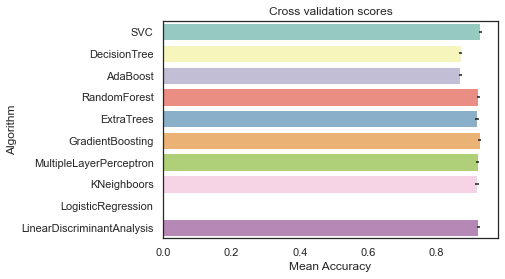

In [16]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, comb_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=8))
print(cv_results)
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


#### 4.2 Parameter tuning for the candidate classifiers

##### SVC Classifier

In [17]:

SVMC = SVC(probability=True)
svc_param_grid = {'C': [1.0],'gamma': ['scale'], 'kernel':['rbf']}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsSVMC.fit(comb_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed: 28.9min remaining: 19.2min
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed: 46.3min finished


0.92865

##### Random Forest Classifier

In [18]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsRFC.fit(comb_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  8.7min
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed: 13.4min finished


0.9195

##### Gradient boosting Classifier

In [19]:

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsGBC.fit(comb_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 22.4min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 129.7min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 291.2min
[Parallel(n_jobs=8)]: Done 720 out of 720 | elapsed: 591.5min finished


0.93285

##### KNeighbors Classifier

In [ ]:

KNei = KNeighborsClassifier()
knei_param_grid = {"n_neighbors": range(1, 20),'weights': ['uniform','distance']}

gsKNei = GridSearchCV(KNei,param_grid = knei_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsKNei.fit(comb_train,y_train)

KNei_best = gsKNei.best_estimator_

# Best score
gsKNei.best_score_


Fitting 10 folds for each of 38 candidates, totalling 380 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


##### Linear Discriminant Analysis

In [ ]:

LDA = LinearDiscriminantAnalysis()
lda_param_grid = lda_param_grid = {"solver" : ["svd"], "tol" : [0.0001,0.0002,0.0003]}

gsLDA = GridSearchCV(LDA,param_grid = lda_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsLDA.fit(comb_train,y_train)

LDA_best = gsLDA.best_estimator_

# Best score
gsLDA.best_score_

### 5. Ensemble modelling

#### 5.1 Combining models

I choosed a voting classifier to combine the predictions coming from the 5 classifiers.
I preferred to pass the argument "soft" to the voting parameter to take into account the probability of each vote.

In [ ]:

votingC = VotingClassifier(estimators=[('svc', SVMC_best), ('rfc', RFC_best),
('gbc',GBC_best),('knei',KNei_best),('lda',LDA_best)], voting='soft', n_jobs=8)

votingC = votingC.fit(comb_train, y_train)

### 6. Load test dataset

In [ ]:

test_data = pd.read_csv('./test.csv')
test_data.head()

### 7. Data Preprocessing for the test dataset

The procedure is same as the data preprocessing for the train dataset.

In [ ]:
resultX = np.array(test_data.DNAsequence)
resultX

In [ ]:
resultX_transformed = vectorizer.transform(resultX).toarray()
resultY_predicted = model.predict_proba(resultX_transformed)[:,1]


In [ ]:
character_matrix_resultX = SplitStringVector(resultX)


In [ ]:
dummies_result = pd.get_dummies(pd.DataFrame(character_matrix_resultX))


In [ ]:
comb_result = np.concatenate((resultX_transformed,dummies_result), axis=1)


### 8. Predict the probability of the test dataset

In [ ]:
y_result_predicted_comb = votingC.predict_proba(comb_result)[:,1]
y_result_predicted_comb

In [ ]:
result_df = pd.DataFrame(y_result_predicted_comb, columns = ['Predicted'])
result_df.index.name = 'Id'
result_df

In [ ]:
result_df.to_csv("528_submission_last.csv")


By a number of experiments, I realized that sklearn classifiers produce the higher score rather than using CNN (Convolutional Neural Network) for this dataset.